In [1]:
from os import listdir
from os.path import isfile, join
import os, sys
sys.path.append('pytorch_sol2/')
sys.path

['/Users/mohamedzayyanvariawa/Documents/machinelearningprojects/Computer Vision/Covid pneumonia',
 '/opt/anaconda3/envs/pytorchenv/lib/python39.zip',
 '/opt/anaconda3/envs/pytorchenv/lib/python3.9',
 '/opt/anaconda3/envs/pytorchenv/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda3/envs/pytorchenv/lib/python3.9/site-packages',
 '/opt/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/aeosa',
 '/opt/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg',
 '/opt/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/IPython/extensions',
 '/Users/mohamedzayyanvariawa/.ipython',
 'pytorch_sol2/']

In [2]:
import pandas as pd
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch.nn.functional as F

In [3]:
from pneumoniaDataset import *

In [4]:
device = torch.device('cpu')

In [5]:
transformations = transforms.Compose([transforms.ToTensor(),
    transforms.Resize((196, 196)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transf = transforms.Compose([transforms.ToTensor(),
                             transforms.Resize((196, 196)),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.RandomRotation(degrees=(0,360)),
                             transforms.RandomVerticalFlip(p=0.5),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])

In [6]:
train_ds = pneumoniaDataset('./data/train/', transform=transf)
test_ds = pneumoniaDataset('./data/test/', transform=transf)
val_ds = pneumoniaDataset('./data/val/', transform=transf)

In [7]:
train_dl = DataLoader(train_ds, batch_size=64, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=64, num_workers=8)
val_dl = DataLoader(val_ds, batch_size=64, num_workers=8)

In [8]:
model = models.resnet18()
layers = []
layers.append(nn.Linear(512, 256))
layers.append(nn.ReLU())
layers.append(nn.Dropout(0.25))
layers.append(nn.Linear(256, 1))
layers.append(nn.Sigmoid())
net = nn.Sequential(*layers)
model.fc = net
#torch.nn.Linear(in_features=2048, out_features=1)
model = model.to(device)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optim.SGD(model.parameters(), lr=0.0001, momentum=0.05, nesterov=True, weight_decay=0.0005)
criterion = torch.nn.BCELoss(reduce='mean')
#nn.MSELoss(reduce='mean')
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3,threshold=0.0001,factor=0.1, verbose=True)

/opt/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [10]:
def train_phase(dl, tr='train'):
    if tr == 'train':
        model.train()
        dl = train_dl
    if tr == 'val':
        model.eval()
        dl = val_dl            
    losses = []
    for i, batch in enumerate(dl):
        inputs, labels = batch['image'], batch['labels'].float().view(-1,1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()             # 1. Zero the parameter gradients
        outputs = model(inputs)           # 2. Run the model

        loss = criterion(outputs, labels) # 3. Calculate loss
        losses.append(loss.item())
        #loss = torch.sqrt(loss)           #    -> RMSE loss
        loss.backward()                   # 4. Backward propagate the loss
        optimizer.step()                  # 5. Optimize the network

        del batch
        del inputs
        del labels
        torch.cuda.empty_cache()
    epoch_loss = sum(losses) / len(losses)
    return epoch_loss

In [11]:
train_losses = []
val_losses = []
epochs = 25
for epoch in range(epochs):
    train_loss = train_phase(train_dl)
    val_loss = train_phase(val_dl, tr='val')
    scheduler.step(val_loss)    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch {}: Train Loss : {}, Val Loss : {}'.format(epoch, train_loss, val_loss))

Epoch 0: Train Loss : 0.9182283741273832, Val Loss : 2.050098820570865
Epoch 1: Train Loss : 0.6980279209938917, Val Loss : 1.3034200773314188
Epoch 2: Train Loss : 0.6889501223058412, Val Loss : 1.052569363047095
Epoch 3: Train Loss : 0.6666255299792145, Val Loss : 1.4865296822527478
Epoch 4: Train Loss : 0.641793069062811, Val Loss : 0.6287038650582818
Epoch 5: Train Loss : 0.6262960596518083, Val Loss : 0.8382590036181843
Epoch 6: Train Loss : 0.6489644149939219, Val Loss : 0.6445798453162698
Epoch 7: Train Loss : 0.6230410703203895, Val Loss : 0.6075053337742301
Epoch 8: Train Loss : 0.6161791131351934, Val Loss : 0.4860879801725626
Epoch 9: Train Loss : 0.6135663268241015, Val Loss : 0.5013682316331303
Epoch 10: Train Loss : 0.6163487520181772, Val Loss : 0.44478370015413554
Epoch 11: Train Loss : 0.6148690152348895, Val Loss : 0.30134387672275326
Epoch 12: Train Loss : 0.6025675955143842, Val Loss : 1.0413832226220299
Epoch 13: Train Loss : 0.6214269792491739, Val Loss : 0.551980

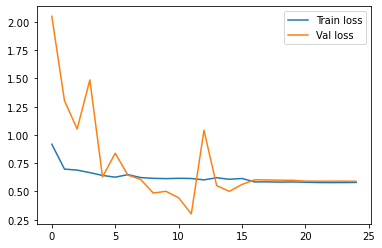

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'])
plt.show()

In [13]:
preds = torch.empty(0, 1)
acts = torch.empty(0,1)
for i, batch in enumerate(test_dl):
    model.eval()
    inputs, actuals = batch['image'], batch['labels'].float().view(-1,1)
    inputs, actuals = inputs.to(device), actuals.to(device)
    preds = torch.cat((preds, model(inputs)), axis=0)
    acts = torch.cat((acts, actuals), axis=0)

In [16]:
preds

tensor([[0.7183],
        [0.7267],
        [0.6915],
        [0.7252],
        [0.7093],
        [0.7062],
        [0.6983],
        [0.6841],
        [0.7201],
        [0.7173],
        [0.7000],
        [0.7243],
        [0.7032],
        [0.6993],
        [0.6942],
        [0.7074],
        [0.6834],
        [0.7224],
        [0.6927],
        [0.6903],
        [0.7159],
        [0.6998],
        [0.6922],
        [0.7228],
        [0.7189],
        [0.7156],
        [0.7243],
        [0.7201],
        [0.7144],
        [0.7145],
        [0.7125],
        [0.7123],
        [0.7224],
        [0.6916],
        [0.7221],
        [0.6965],
        [0.7170],
        [0.7178],
        [0.6972],
        [0.7181],
        [0.7045],
        [0.7202],
        [0.6922],
        [0.7209],
        [0.7126],
        [0.7147],
        [0.7094],
        [0.7044],
        [0.7150],
        [0.7201],
        [0.7145],
        [0.6989],
        [0.7064],
        [0.6923],
        [0.7270],
        [0

In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve
def threshold_from_optimal_tpr_minus_fpr(y_actuals,y_scores):
    fpr, tpr, thresholds = roc_curve(y_actuals, y_scores) 

    optimal_idx = np.argmax(tpr - fpr)

    return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]


def threshold_from_optimal_f_score(y_actuals,y_scores):
    precisions, recalls, thresholds = precision_recall_curve(y_actuals, y_scores)

    fscores = (2 * precisions * recalls) / (precisions + recalls)

    optimal_idx = np.argmax(fscores)

    return thresholds[optimal_idx], fscores[optimal_idx]

def threshold_from_desired_precision(y_actuals, y_scores, desired_precision=0.9):
    precisions, recalls, thresholds = precision_recall_curve(y_actuals, y_scores)

    desired_precision_idx = np.argmax(precisions >= desired_precision)

    return thresholds[desired_precision_idx], recalls[desired_precision_idx]
#threshold, optimal_tpr_minus_fpr = threshold_from_optimal_tpr_minus_fpr(acts.detach().numpy(), preds.detach().numpy())
#threshold, optimal_f1_score = threshold_from_optimal_f_score(acts.detach().numpy(), preds.detach().numpy())
threshold, optimal_recall = threshold_from_desired_precision(acts.detach().numpy(), preds.detach().numpy())

In [35]:
testDf = pd.DataFrame(data=acts.detach().numpy(), columns=['Actual'])
testDf['Preds'] = preds.detach().numpy()
testDf['Preds'] = testDf['Preds'].apply(lambda x: 1 if x > threshold else 0)
print(round(testDf[testDf['Actual'] == testDf['Preds']].shape[0]/testDf.shape[0],4))

0.7115


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testDf['Actual'], testDf['Preds'])

array([[208,  26],
       [154, 236]])

In [27]:
#torch.save(model.state_dict(), './Model/bce_model')
#model.load_state_dict(torch.load(PATH))

In [6]:
image = cv2.imread('./data/train/normal/IM-0561-0001.jpeg')
image.shape

(1963, 2172, 3)

In [5]:
listdir('./data/train/normal')

['NORMAL2-IM-0927-0001.jpeg',
 'IM-0427-0001.jpeg',
 'IM-0656-0001-0001.jpeg',
 'IM-0561-0001.jpeg',
 'IM-0757-0001.jpeg',
 'NORMAL2-IM-0736-0001.jpeg',
 'NORMAL2-IM-0500-0001.jpeg',
 'NORMAL2-IM-0393-0001.jpeg',
 'NORMAL2-IM-0994-0001.jpeg',
 'IM-0207-0001.jpeg',
 'IM-0494-0001.jpeg',
 'IM-0177-0001.jpeg',
 'IM-0388-0001.jpeg',
 'IM-0341-0001.jpeg',
 'IM-0355-0001.jpeg',
 'IM-0449-0001.jpeg',
 'IM-0480-0001.jpeg',
 'NORMAL2-IM-1038-0001.jpeg',
 'IM-0739-0001.jpeg',
 'IM-0213-0001.jpeg',
 'NORMAL2-IM-0452-0001.jpeg',
 'NORMAL2-IM-0980-0001.jpeg',
 'NORMAL2-IM-0949-0001.jpeg',
 'NORMAL2-IM-0664-0001.jpeg',
 'IM-0269-0001.jpeg',
 'IM-0575-0001.jpeg',
 'IM-0605-0001.jpeg',
 'IM-0433-0001.jpeg',
 'IM-0119-0001.jpeg',
 'NORMAL2-IM-0875-0001.jpeg',
 'NORMAL2-IM-0428-0001.jpeg',
 'NORMAL2-IM-0933-0001.jpeg',
 'NORMAL2-IM-0684-0001-0001.jpeg',
 'NORMAL2-IM-1019-0001.jpeg',
 'IM-0453-0001-0002.jpeg',
 'IM-0374-0001.jpeg',
 'IM-0697-0001.jpeg',
 'IM-0718-0001.jpeg',
 'NORMAL2-IM-0645-0001.jpeg',

In [55]:
create_df = True
if create_df:
    folders = ['train', 'test', 'val']
    classes = ['normal', 'opacity']
    mypath = './data/{}/{}'

    train_normal = [f for f in listdir(mypath.format('train', 'normal')) if isfile(join(mypath.format('train', 'normal'), f))]
    train_normal_label = ['Normal']* len(train_normal)
    train_opacity = [f for f in listdir(mypath.format('train', 'opacity')) if isfile(join(mypath.format('train', 'opacity'), f))]
    train_opacity_label = ['Opacity'] * len(train_opacity)
    
    test_normal = [f for f in listdir(mypath.format('test', 'normal')) if isfile(join(mypath.format('test', 'normal'), f))]
    test_normal_label = ['Normal']* len(test_normal)
    test_opacity = [f for f in listdir(mypath.format('test', 'opacity')) if isfile(join(mypath.format('test', 'opacity'), f))]
    test_opacity_label = ['Opacity'] * len(test_opacity)
    
    
    val_normal = [f for f in listdir(mypath.format('val', 'normal')) if isfile(join(mypath.format('val', 'normal'), f))]
    val_normal_label = ['Normal']* len(val_normal)
    val_opacity = [f for f in listdir(mypath.format('val', 'opacity')) if isfile(join(mypath.format('val', 'opacity'), f))]
    val_opacity_label = ['Opacity'] * len(val_opacity)
    
    train_df = pd.DataFrame(data=train_normal+train_opacity, columns=['id'])
    train_df['label'] = train_normal_label + train_opacity_label
    train_df = pd.get_dummies(train_df, prefix=[''], prefix_sep=[''],columns=['label'])
    
    test_df = pd.DataFrame(data=test_normal+test_opacity, columns=['id'])
    test_df['label'] = test_normal_label + test_opacity_label
    test_df = pd.get_dummies(test_df, prefix=[''], prefix_sep=[''],columns=['label'])
    
    val_df = pd.DataFrame(data=val_normal+val_opacity, columns=['id'])
    val_df['label'] = val_normal_label + val_opacity_label
    val_df = pd.get_dummies(val_df, prefix=[''], prefix_sep=[''],columns=['label'])
    
    train_df.to_csv('./classes/train_df.csv', index=False)
    test_df.to_csv('./classes/test_df.csv', index=False)
    val_df.to_csv('./classes/val_df.csv', index=False)
    